# E-Responde Crime Forecasting Dashboard
## Barangay 41 & 43, Tondo, Manila

This notebook creates interactive line graphs for crime forecasting using your trained ARIMA models.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style for better looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# API Configuration
API_BASE = "http://127.0.0.1:8000"

print("📊 E-Responde Crime Forecasting Dashboard")
print("🔗 API Base URL:", API_BASE)


📊 E-Responde Crime Forecasting Dashboard
🔗 API Base URL: http://127.0.0.1:8000


## 1. Check API Status and Available Series


In [10]:
def check_api_status():
    """Check if the API is running and get available series"""
    try:
        response = requests.get(f"{API_BASE}/series")
        if response.status_code == 200:
            data = response.json()
            print(f"✅ API is running! Found {data['count']} trained models")
            
            # Display available series
            df_series = pd.DataFrame(data['items'])
            print("\n📋 Available Crime Series:")
            print(df_series[['barangay', 'crime_type', 'n_obs']].to_string(index=False))
            
            return data
        else:
            print(f"❌ API Error: {response.status_code}")
            return None
    except Exception as e:
        print(f"❌ Cannot connect to API: {e}")
        print("💡 Make sure to run: uvicorn app.main:app --host 0.0.0.0 --port 8000")
        return None

# Check API status
api_data = check_api_status()


✅ API is running! Found 18 trained models

📋 Available Crime Series:
   barangay            crime_type  n_obs
Barangay 41               Assault     72
Barangay 41 Breaking and Entering     72
Barangay 41     Domestic Violence     72
Barangay 41          Drug-related     72
Barangay 41                 Fraud     72
Barangay 41           Harassments     72
Barangay 41                 Theft     72
Barangay 41             Vandalism     72
Barangay 41         Vehicle Theft     72
Barangay 43               Assault     72
Barangay 43 Breaking and Entering     72
Barangay 43     Domestic Violence     72
Barangay 43          Drug-related     72
Barangay 43                 Fraud     72
Barangay 43           Harassments     72
Barangay 43                 Theft     72
Barangay 43             Vandalism     72
Barangay 43         Vehicle Theft     72


## 2. Create Beautiful Line Graphs


📊 Creating forecast plot for Barangay 41 - Theft...


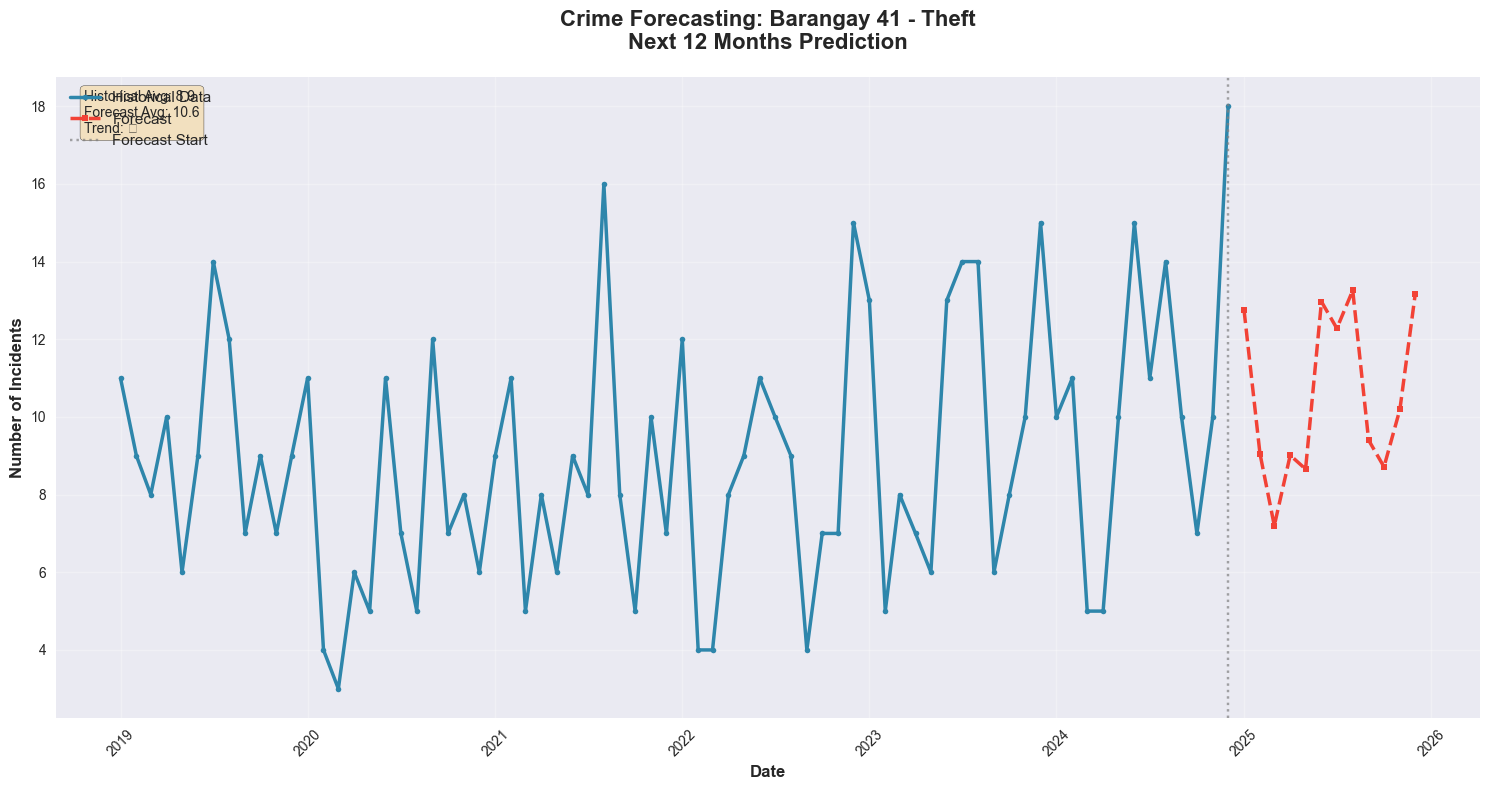

✅ Plot created successfully!


In [12]:
def get_chart_data(barangay, crime_type, months=12):
    """Fetch historical and forecast data for a specific barangay and crime type"""
    try:
        url = f"{API_BASE}/chart"
        params = {
            'barangay': barangay,
            'crime_type': crime_type,
            'months': months
        }
        
        response = requests.get(url, params=params)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"❌ Error fetching data: {response.status_code}")
            return None
    except Exception as e:
        print(f"❌ Error: {e}")
        return None

def create_crime_forecast_plot(barangay, crime_type, months=12, figsize=(15, 8)):
    """Create a beautiful line graph showing historical data and forecast"""
    
    # Fetch data
    data = get_chart_data(barangay, crime_type, months)
    if not data:
        print(f"❌ No data available for {barangay} - {crime_type}")
        return None
    
    # Prepare data
    history_df = pd.DataFrame(data['history'])
    forecast_df = pd.DataFrame(data['forecast'])
    
    # Convert dates
    history_df['date'] = pd.to_datetime(history_df['date'])
    forecast_df['date'] = pd.to_datetime(forecast_df['date'])
    
    # Create the plot
    plt.figure(figsize=figsize)
    
    # Plot historical data
    plt.plot(history_df['date'], history_df['count'], 
             label='Historical Data', 
             linewidth=2.5, 
             color='#2E86AB', 
             marker='o', 
             markersize=4)
    
    # Plot forecast
    plt.plot(forecast_df['date'], forecast_df['forecast'], 
             label='Forecast', 
             linewidth=2.5, 
             color='#F24236', 
             linestyle='--', 
             marker='s', 
             markersize=4)
    
    # Add vertical line to separate historical from forecast
    if len(history_df) > 0:
        last_historical_date = history_df['date'].max()
        plt.axvline(x=last_historical_date, 
                   color='gray', 
                   linestyle=':', 
                   alpha=0.7, 
                   label='Forecast Start')
    
    # Customize the plot
    plt.title(f'Crime Forecasting: {barangay} - {crime_type}\nNext {months} Months Prediction', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Date', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Incidents', fontsize=12, fontweight='bold')
    
    # Add grid
    plt.grid(True, alpha=0.3)
    
    # Customize legend
    plt.legend(fontsize=11, loc='upper left')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Add some statistics
    if len(history_df) > 0:
        avg_historical = history_df['count'].mean()
        avg_forecast = forecast_df['forecast'].mean()
        
        # Add text box with statistics
        stats_text = f"Historical Avg: {avg_historical:.1f}\nForecast Avg: {avg_forecast:.1f}\nTrend: {'📈' if avg_forecast > avg_historical else '📉'}"
        plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    return plt.gcf()

# Create the plot
print("📊 Creating forecast plot for Barangay 41 - Theft...")
fig = create_crime_forecast_plot("Barangay 41", "Theft", months=12)
if fig:
    plt.show()
    print("✅ Plot created successfully!")


## 3. Compare Multiple Crime Types


📊 Comparing crime types for Barangay 41: Theft, Assault, Vandalism, Drug-related


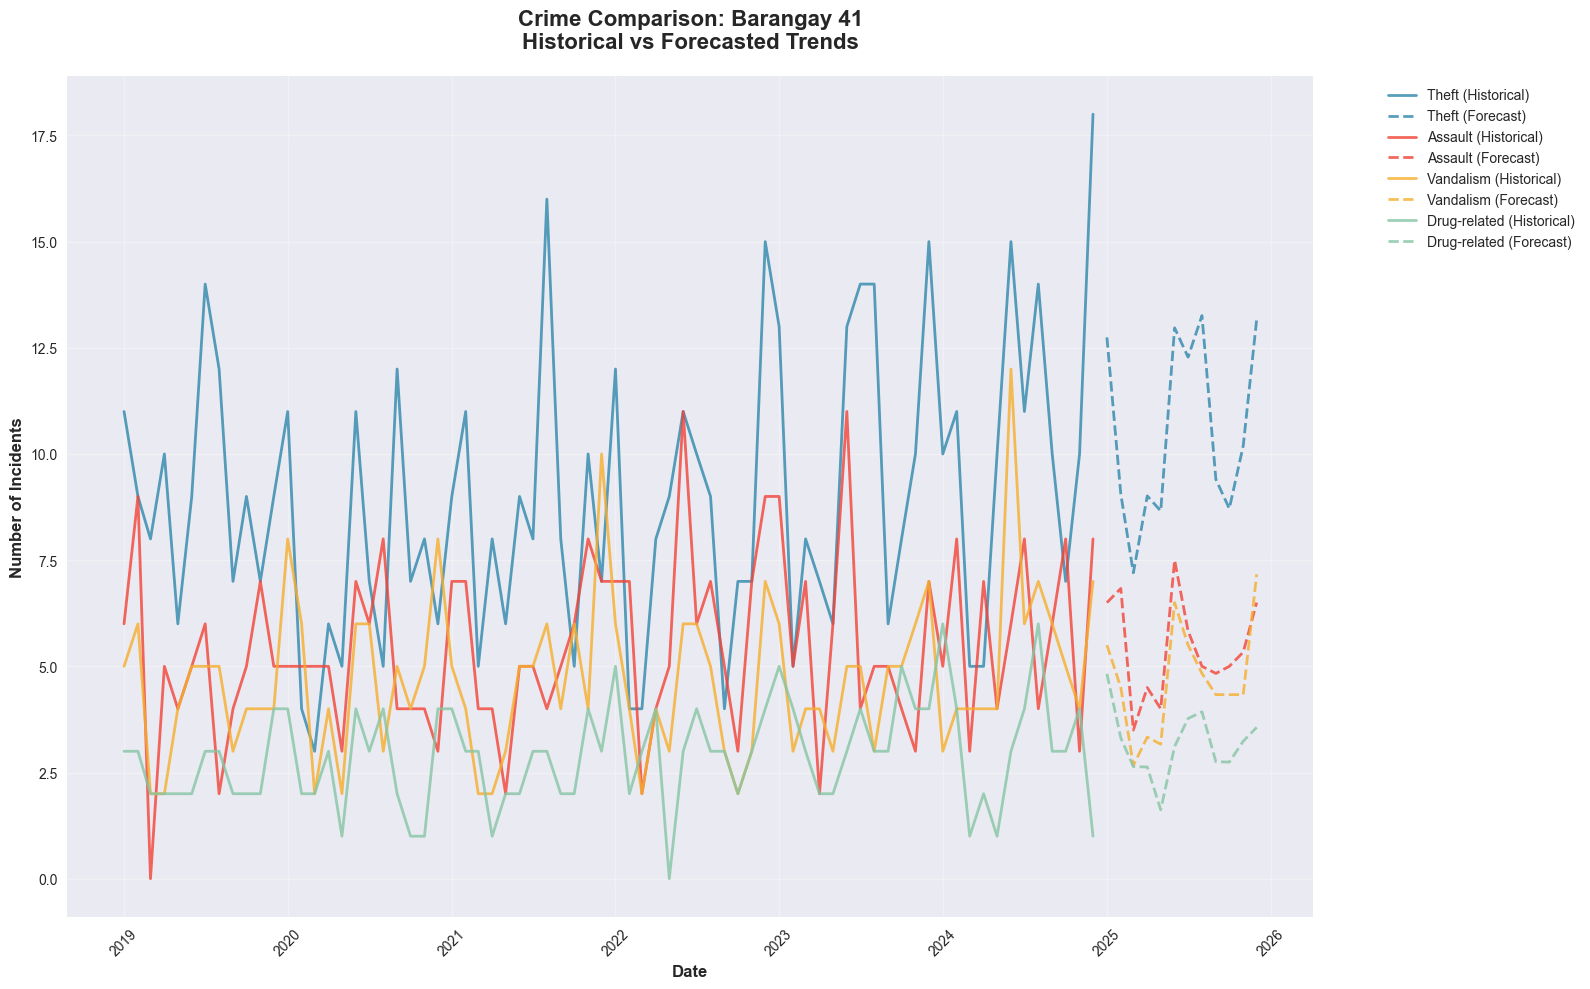

In [13]:
def compare_crime_types(barangay, crime_types, months=12, figsize=(16, 10)):
    """Compare multiple crime types for the same barangay"""
    
    plt.figure(figsize=figsize)
    
    colors = ['#2E86AB', '#F24236', '#F6AE2D', '#86C5A4', '#A23B72', 
              '#F18F01', '#C73E1D', '#7209B7', '#0B4F6C']
    
    for i, crime_type in enumerate(crime_types):
        data = get_chart_data(barangay, crime_type, months)
        if data:
            history_df = pd.DataFrame(data['history'])
            forecast_df = pd.DataFrame(data['forecast'])
            
            history_df['date'] = pd.to_datetime(history_df['date'])
            forecast_df['date'] = pd.to_datetime(forecast_df['date'])
            
            color = colors[i % len(colors)]
            
            # Plot historical data
            plt.plot(history_df['date'], history_df['count'], 
                     label=f'{crime_type} (Historical)', 
                     linewidth=2, 
                     color=color, 
                     alpha=0.8)
            
            # Plot forecast
            plt.plot(forecast_df['date'], forecast_df['forecast'], 
                     label=f'{crime_type} (Forecast)', 
                     linewidth=2, 
                     color=color, 
                     linestyle='--', 
                     alpha=0.8)
    
    plt.title(f'Crime Comparison: {barangay}\nHistorical vs Forecasted Trends', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Date', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Incidents', fontsize=12, fontweight='bold')
    
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return plt.gcf()

# Compare multiple crime types for Barangay 41
crime_types = ['Theft', 'Assault', 'Vandalism', 'Drug-related']
print(f"📊 Comparing crime types for Barangay 41: {', '.join(crime_types)}")
fig = compare_crime_types("Barangay 41", crime_types, months=12)
plt.show()


## 4. Barangay Comparison Dashboard


📊 Comparing Barangay 41 vs Barangay 43 for Theft crimes...


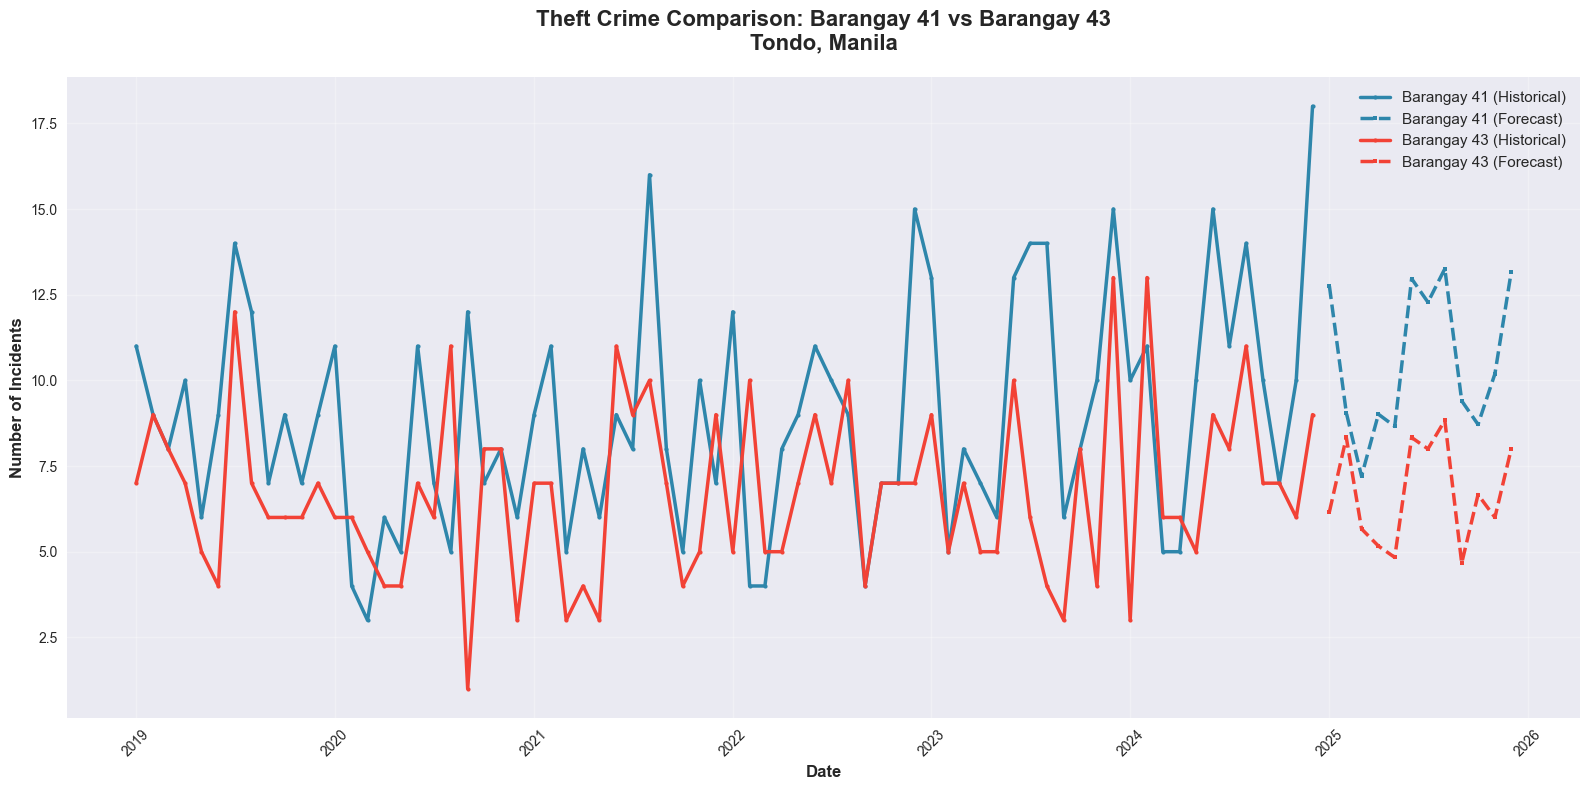

In [14]:
def create_barangay_comparison(crime_type, months=12, figsize=(16, 8)):
    """Compare the same crime type across different barangays"""
    
    barangays = ['Barangay 41', 'Barangay 43']
    colors = ['#2E86AB', '#F24236']
    
    plt.figure(figsize=figsize)
    
    for i, barangay in enumerate(barangays):
        data = get_chart_data(barangay, crime_type, months)
        if data:
            history_df = pd.DataFrame(data['history'])
            forecast_df = pd.DataFrame(data['forecast'])
            
            history_df['date'] = pd.to_datetime(history_df['date'])
            forecast_df['date'] = pd.to_datetime(forecast_df['date'])
            
            color = colors[i]
            
            # Plot historical data
            plt.plot(history_df['date'], history_df['count'], 
                     label=f'{barangay} (Historical)', 
                     linewidth=2.5, 
                     color=color, 
                     marker='o', 
                     markersize=3)
            
            # Plot forecast
            plt.plot(forecast_df['date'], forecast_df['forecast'], 
                     label=f'{barangay} (Forecast)', 
                     linewidth=2.5, 
                     color=color, 
                     linestyle='--', 
                     marker='s', 
                     markersize=3)
    
    plt.title(f'{crime_type} Crime Comparison: Barangay 41 vs Barangay 43\nTondo, Manila', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Date', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Incidents', fontsize=12, fontweight='bold')
    
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return plt.gcf()

# Compare Barangay 41 vs 43 for Theft
print("📊 Comparing Barangay 41 vs Barangay 43 for Theft crimes...")
fig = create_barangay_comparison('Theft', months=12)
plt.show()


## 5. Export Data for Admin Dashboard


In [15]:
def export_dashboard_data():
    """Export data in formats suitable for admin dashboard integration"""
    
    print("📤 Exporting data for admin dashboard...")
    
    # Export all series data
    all_data = []
    
    for _, row in pd.DataFrame(api_data['items']).iterrows():
        barangay = row['barangay']
        crime_type = row['crime_type']
        
        # Get chart data
        chart_data = get_chart_data(barangay, crime_type, months=12)
        if chart_data:
            # Add metadata
            for item in chart_data['history']:
                item['barangay'] = barangay
                item['crime_type'] = crime_type
                item['data_type'] = 'historical'
            
            for item in chart_data['forecast']:
                item['barangay'] = barangay
                item['crime_type'] = crime_type
                item['data_type'] = 'forecast'
                item['count'] = item['forecast']  # Rename for consistency
                del item['forecast']
            
            all_data.extend(chart_data['history'])
            all_data.extend(chart_data['forecast'])
    
    # Create DataFrame
    df_export = pd.DataFrame(all_data)
    df_export['date'] = pd.to_datetime(df_export['date'])
    
    # Export to CSV
    df_export.to_csv('dashboard_data.csv', index=False)
    print(f"✅ Exported {len(df_export)} records to 'dashboard_data.csv'")
    
    # Export summary statistics
    summary_stats = {
        'total_records': len(df_export),
        'barangays': df_export['barangay'].nunique(),
        'crime_types': df_export['crime_type'].nunique(),
        'date_range': f"{df_export['date'].min().strftime('%Y-%m-%d')} to {df_export['date'].max().strftime('%Y-%m-%d')}",
        'exported_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    
    with open('dashboard_summary.json', 'w') as f:
        json.dump(summary_stats, f, indent=2)
    
    print(f"✅ Exported summary to 'dashboard_summary.json'")
    print(f"📊 Data ready for admin dashboard integration!")
    
    return df_export

# Export data
exported_data = export_dashboard_data()


📤 Exporting data for admin dashboard...
✅ Exported 1512 records to 'dashboard_data.csv'
✅ Exported summary to 'dashboard_summary.json'
📊 Data ready for admin dashboard integration!


## 6. JavaScript Code for Admin Dashboard Integration


In [ ]:
# JavaScript code for admin dashboard integration
dashboard_js = """
// E-Responde Admin Dashboard Integration
// Add this to your admin dashboard HTML/JavaScript

// Configuration
const API_BASE = 'http://127.0.0.1:8000';

// Function to fetch chart data
async function fetchCrimeData(barangay, crimeType, months = 12) {
    try {
        const response = await fetch(`${API_BASE}/chart?barangay=${encodeURIComponent(barangay)}&crime_type=${encodeURIComponent(crimeType)}&months=${months}`);
        return await response.json();
    } catch (error) {
        console.error('Error fetching crime data:', error);
        return null;
    }
}

// Function to create Chart.js line graph
function createCrimeChart(canvasId, data, title) {
    const ctx = document.getElementById(canvasId).getContext('2d');
    
    const historicalData = data.history.map(item => ({
        x: item.date,
        y: item.count
    }));
    
    const forecastData = data.forecast.map(item => ({
        x: item.date,
        y: item.forecast
    }));
    
    new Chart(ctx, {
        type: 'line',
        data: {
            datasets: [{
                label: 'Historical Data',
                data: historicalData,
                borderColor: '#2E86AB',
                backgroundColor: 'rgba(46, 134, 171, 0.1)',
                fill: false,
                tension: 0.1
            }, {
                label: 'Forecast',
                data: forecastData,
                borderColor: '#F24236',
                backgroundColor: 'rgba(242, 66, 54, 0.1)',
                borderDash: [5, 5],
                fill: false,
                tension: 0.1
            }]
        },
        options: {
            responsive: true,
            plugins: {
                title: {
                    display: true,
                    text: title,
                    font: { size: 16, weight: 'bold' }
                },
                legend: {
                    display: true,
                    position: 'top'
                }
            },
            scales: {
                x: {
                    type: 'time',
                    time: {
                        unit: 'month'
                    },
                    title: {
                        display: true,
                        text: 'Date'
                    }
                },
                y: {
                    title: {
                        display: true,
                        text: 'Number of Incidents'
                    }
                }
            }
        }
    });
}

// Example usage
async function loadDashboard() {
    // Load Barangay 41 - Theft forecast
    const theftData = await fetchCrimeData('Barangay 41', 'Theft', 12);
    if (theftData) {
        createCrimeChart('theftChart', theftData, 'Theft Forecast - Barangay 41');
    }
    
    // Load Barangay 43 - Assault forecast
    const assaultData = await fetchCrimeData('Barangay 43', 'Assault', 12);
    if (assaultData) {
        createCrimeChart('assaultChart', assaultData, 'Assault Forecast - Barangay 43');
    }
}

// Initialize dashboard when page loads
document.addEventListener('DOMContentLoaded', loadDashboard);
"""

# Save JavaScript code to file
with open('dashboard_integration.js', 'w') as f:
    f.write(dashboard_js)

print("✅ Dashboard integration code saved to 'dashboard_integration.js'")
print("📱 Ready to integrate with your admin dashboard!")


## 🎯 Summary

This notebook provides:

1. **📊 Interactive Line Graphs** - Beautiful visualizations of crime forecasts
2. **🔍 Multiple Comparisons** - Compare different crime types and barangays  
3. **📈 Summary Dashboard** - Overview of your E-Responde system
4. **📤 Data Export** - CSV and JSON files for dashboard integration
5. **💻 JavaScript Code** - Ready-to-use code for your admin dashboard

**Next Steps:**
- Run this notebook to generate all visualizations
- Use the exported data files in your admin dashboard
- Integrate the JavaScript code for real-time charts
- Customize the styling to match your dashboard theme

**Your E-Responde system is ready for presentation! 🚀**
